In [10]:
%pip uninstall torch torch_geometric torch_scatter torch_sparse pyg_lib torch_cluster torch_spline_conv -y
# 2.1 PyTorch (CPU) – подмените индекс, если нужна CUDA
%pip install torch==2.3.0

# 2.2 PyG: с 2.3+ внешних библиотек почти нет, ставим одной строкой
%pip install torch_geometric
%pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html


# 2.4 остальное
%pip install xgboost pandas matplotlib graphviz scikit-learn tqdm numpy networkx seaborn


Found existing installation: torch 2.3.0
Uninstalling torch-2.3.0:
  Successfully uninstalled torch-2.3.0
Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.3.0-cp39-none-macosx_11_0_arm64.whl.metadata (26 kB)
Using cached torch-2.3.0-cp39-none-macosx_11_0_arm64.whl (61.0 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.3.0%2Bcpu/torch_scatter-2.1.2-cp39-cp39-macosx_10_9_universal2.whl (555 kB)
  Using cached https://data.pyg.org/whl/torch-2.3.0%2Bcpu/torch_sparse-0.6.18-cp39-cp39-macosx_11

In [34]:
from pathlib import Path
import networkx as nx
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import to_undirected
import math
import torch_cluster

print(torch.__version__)

2.3.0


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Чтение датасета

In [36]:
from pathlib import Path
ACCOUNTS_CSV = Path('./tmp/Ethereum/account.csv')      # обновите при необходимости
TXS_CSV      = Path('./tmp/Ethereum/transaction.csv')   # обновите при необходимости

assert ACCOUNTS_CSV.exists(), f'{ACCOUNTS_CSV} not found'
assert TXS_CSV.exists(), f'{TXS_CSV} not found'

In [37]:
acc_df = pd.read_csv(ACCOUNTS_CSV, header=None, names=['id', 'label'])
tx_df  = pd.read_csv(TXS_CSV, header=None, names=['src', 'dst', 'amount', 'timestamp'])

display(acc_df.head())
display(tx_df.head())

,id,label
0,0x8335392fe1b236296c5d5f653264396de165e46c,True
1,0x9d4b62503b4b7993182323effe6245f6d77e4413,True
2,0xc91293245b669da19a96cd85d40bb9c203359657,True
3,0x1056d8d9ebb0e0d8710a0e2a1852d4a09d56464a,True
4,0x4f1872383be22878af5d4795b69be61b35ec5d10,True


,src,dst,amount,timestamp
0,0x21f74c6bbc1e3ab9f0205e12de3a9daa14351aed,0x46f1c0481803cb34a7860d614b5430c5db51bfb7,5.00000,1.502740e+09
1,0x54008c2684d96c44a094dc127842ec144b157e96,0x1acee83486b6671b005eed45c9fb9277e7eeb63d,2.34758,1.518731e+09
2,0x97aeb9b292c00405e145d9c7a8429bc970fa0e65,0x4f00b95c625c6d6ef72748d78c750fd6c84a8b85,0.01003,1.516224e+09
3,0x2dfdf31bbc29468d487591f292872a14c1f8d1f0,0x474057adf42f9f955e86aa1142740f9d7763e41e,0.51587,1.522422e+09
4,0x5b39067ee0309856edd13f23c9c1793f9fda1b4f,0x6376baf58c4c5d70ba8fca9565b6955f07c584a9,6.67000,1.514817e+09


## 🏗️ Сборка графа

In [38]:
G = nx.DiGraph()

# add nodes
for _, row in acc_df.iterrows():
    G.add_node(row.id, label=int(bool(row.label)))

# add edges
for _, row in tx_df.iterrows():
    G.add_edge(row.src, row.dst, amount=float(row.amount), ts=float(row.timestamp))

print(f'Граф содержит {G.number_of_nodes():,} узлов и {G.number_of_edges():,} рёбер')

Граф содержит 32,168 узлов и 42,044 рёбер


In [39]:
# Структурные признаки
in_deg  = dict(G.in_degree())
out_deg = dict(G.out_degree())

# Финансовые суммы
sent_sum = {n: 0.0 for n in G.nodes()}
recv_sum = {n: 0.0 for n in G.nodes()}
for u, v, d in G.edges(data=True):
    amt = d['amount']
    sent_sum[u] += amt
    recv_sum[v] += amt

# PageRank и кластерный коэффициент
pr = nx.pagerank(G, alpha=0.85)
clust = nx.clustering(G.to_undirected())

# Записываем фичи в граф
for n in G.nodes():
    G.nodes[n].update({
        'in_deg':      in_deg.get(n, 0),
        'out_deg':     out_deg.get(n, 0),
        'sent_sum':    sent_sum[n],
        'recv_sum':    recv_sum[n],
        'net_sum':     sent_sum[n] - recv_sum[n],
        'pagerank':    pr[n],
        'clustering':  clust[n],
    })

# --- после расчёта pr и clust --------------------------------------------
print('⏳ Calculating extra graph features…')

# 1) Betweenness (approx)
btw = nx.betweenness_centrality(G, k=10_000, seed=42, normalized=True)

# 2) Weakly-connected component size
G_u = G.to_undirected()
wcc = {n: 0 for n in G}
for comp in nx.connected_components(G_u):
    size = len(comp)
    for n in comp:
        wcc[n] = size

# 3) Min amounts
send_min = {n: math.inf for n in G}
recv_min = {n: math.inf for n in G}
for u, v, d in G.edges(data=True):
    amt = d['amount']
    send_min[u] = min(send_min[u], amt)
    recv_min[v] = min(recv_min[v], amt)
# заменяем inf → 0.0 (узлы без операций)
send_min = {n: 0.0 if math.isinf(v) else v for n, v in send_min.items()}
recv_min = {n: 0.0 if math.isinf(v) else v for n, v in recv_min.items()}

# --- записываем все новые фичи в вершины ----------------------------------
for n in G.nodes():
    G.nodes[n].update({
        'btw_centr':   btw[n],
        'wcc_size':    wcc[n],
        'send_min':    send_min[n],
        'recv_min':    recv_min[n],
    })

⏳ Calculating extra graph features…


In [ ]:
 # --- перед обучением Node2Vec: создаём маппинг id → idx -------------------
id2idx = {n: i for i, n in enumerate(G.nodes())}

# --- строим edge_index по числовым индексам ------------------------------
edges = list(G.edges())
row = [id2idx[u] for u, v in edges]
col = [id2idx[v] for u, v in edges]
edge_index = torch.tensor([row, col], dtype=torch.long)
edge_index = to_undirected(edge_index).contiguous()

# --- теперь обучаем Node2Vec на неориентированном графе --------------------
print('⏳ Training Node2Vec…')
n2v = Node2Vec(
    edge_index=edge_index,
    num_nodes=G.number_of_nodes(),
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=5,
    num_negative_samples=1,
    sparse=True,
    p=1, q=1
).to(device)

loader = n2v.loader(batch_size=1024, shuffle=True)
opt = torch.optim.SparseAdam(list(n2v.parameters()), lr=0.01)

n2v.train()
for epoch in range(40):  # можете увеличить число эпох
    total_loss = 0
    for pos_rw, neg_rw in loader:
        opt.zero_grad()
        loss = n2v.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss {total_loss:.4f}')

⏳ Training Node2Vec…
Epoch 1, Loss 246.0344
Epoch 2, Loss 185.5990
Epoch 3, Loss 150.2787
Epoch 4, Loss 122.1331
Epoch 5, Loss 99.6138


In [41]:
# --- извлекаем эмбеддинги и записываем обратно в G ------------------------
z = n2v.embedding.weight.detach().cpu()
for n, idx in id2idx.items():
    G.nodes[n]['n2v'] = z[idx]

# --- при формировании data.x ---------------------------------------------
# Наконец, собираем x
num_attr_keys = [
    'in_deg','out_deg','sent_sum','recv_sum','net_sum',
    'pagerank','clustering',
    'btw_centr','wcc_size','send_min','recv_min'
]

for n in G.nodes():
    # проверяем, что всё есть
    missing = [k for k in num_attr_keys if k not in G.nodes[n]]
    if missing:
        raise RuntimeError(f"У узла {n} нет фичей {missing}")
    base = [float(G.nodes[n][k]) for k in num_attr_keys]
    emb  = G.nodes[n]['n2v'].tolist()           # 128-мерный эмбеддинг
    G.nodes[n]['x'] = torch.tensor(base + emb, dtype=torch.float)

print('Пример фич узла:', list(G.nodes(data=True))[0])

Пример фич узла: ('0x8335392fe1b236296c5d5f653264396de165e46c', {'label': 1, 'in_deg': 4, 'out_deg': 1, 'sent_sum': 3.49954, 'recv_sum': 3.4999599999999997, 'net_sum': -0.0004199999999996429, 'pagerank': 4.475874254314406e-05, 'clustering': 0, 'btw_centr': 0.0, 'wcc_size': 30701, 'send_min': 3.49954, 'recv_min': 0.5, 'n2v': tensor([-0.3263, -0.9942, -0.4803,  0.5377, -0.5554, -0.6436,  0.5854, -0.8306,
         0.4574,  0.8498,  1.2007, -1.0742, -0.5128, -0.3223, -0.0596, -0.1528,
         0.9123,  0.5771,  0.8630,  1.2475, -0.4094, -0.5058, -0.5839, -1.5232,
        -0.4698, -0.3420,  0.9764,  0.1384, -0.5216, -0.3267,  0.4469, -0.4312,
         0.1008, -1.3053,  0.7192, -1.2030,  0.0521, -0.1258,  0.6617,  0.0397,
        -0.6533, -0.6969, -0.6242, -0.0925,  0.2065,  0.6458,  0.6187,  0.5766,
         1.0146,  0.9408,  0.5583,  0.5236, -0.3055,  0.9530, -0.2336, -0.7888,
        -1.3516,  0.7423,  0.7200,  0.6539,  0.5183,  0.2476,  0.2971, -0.5402,
        -0.7539,  0.5327,  0.2945,

In [42]:
# 🔧 Делаем так, чтобы у всех узлов была метка
nx.set_node_attributes(G, -1, "label")        # сначала всем ставим -1
for _, row in acc_df.iterrows():              # затем переопределяем тем, что есть в accounts.csv
    G.nodes[row.id]["label"] = int(bool(row.label))   

In [43]:
# после формирования всех численных признаков, до отправки в PyG
from sklearn.preprocessing import StandardScaler
X = np.stack([G.nodes[n]['x'].numpy() for n in G.nodes()])
scaler = StandardScaler()
X = scaler.fit_transform(X)
for n, vec in zip(G.nodes(), X):
    G.nodes[n]['x'] = torch.tensor(vec, dtype=torch.float)

## 🔄 Конвертация в `torch_geometric.data.Data`

In [56]:
num_attr_keys = ['in_deg','out_deg','sent_sum','recv_sum','net_sum','pagerank','clustering']

for n in G.nodes():
    G.nodes[n]['x'] = torch.tensor([float(G.nodes[n][k]) for k in num_attr_keys], dtype=torch.float)

data = from_networkx(G, group_node_attrs=['x'])
data.y = torch.tensor([G.nodes[n].get('label', -1) for n in G.nodes()], dtype=torch.long)

print("Num features:", data.num_node_features)  
print(data)

Num features: 7
Data(edge_index=[2, 42044], label=[32168], in_deg=[32168], out_deg=[32168], sent_sum=[32168], recv_sum=[32168], net_sum=[32168], pagerank=[32168], clustering=[32168], btw_centr=[32168], wcc_size=[32168], send_min=[32168], recv_min=[32168], n2v=[32168, 128], amount=[42044], ts=[42044], x=[32168, 7], y=[32168])


In [57]:
import torch

# 1) Список «старых» фичей уже в data.x: shape [N,7]
X_base = data.x                # float32, device может быть CPU или CUDA

# 2) Достаём остальные скалярные фичи и приводим к форме [N,1]
btw      = data.btw_centr.view(-1,1)   # [N] → [N,1]
wcc      = data.wcc_size.view(-1,1)
send_min = data.send_min.view(-1,1)
recv_min = data.recv_min.view(-1,1)

# 3) Node2Vec: shape [N,128]
X_n2v    = data.n2v               # уже [N,128]

# 4) Конкатенируем всё в один [N, 7+4+128 = 139]
data.x = torch.cat([X_base, btw, wcc, send_min, recv_min, X_n2v], dim=1)

print("Now num features:", data.x.size(1))  # должно быть 139

Now num features: 139


In [58]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1) выгружаем data.x в NumPy
X = data.x.cpu().numpy()   # shape [N,139]

# 2) лог-трансформации неотрицательных признаков
log_idxs = [0,1,2,3,7,8,9,10]
X[:, log_idxs] = np.log1p(X[:, log_idxs])

# 3) чистим NaN/Inf → конечные числа
#    nan → 0.0, +inf → max_float32, -inf → min_float32
X = np.nan_to_num(
    X,
    nan=0.0,
    posinf=np.finfo(np.float32).max,
    neginf=np.finfo(np.float32).min
)

# (можно проверить, что теперь все конечные)
assert np.isfinite(X).all(), "Есть ещё не-конечные элементы!"

# 4) стандартизация
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 5) обратно в TorchTensor
import torch
data.x = torch.tensor(X, dtype=torch.float32).to(device)

## ✂️ Train / Val / Test сплит

In [59]:
import hashlib
import numpy as np
import torch

# 1) Собираем список узлов в порядке G.nodes()
nodes = list(G.nodes())

# 2) Хешируем каждый ID (md5 → целое), берём mod 100 → [0..99]
hash_vals = np.array([
    int(hashlib.md5(str(n).encode()).hexdigest(), 16) % 100
    for n in nodes
])

# 3) Порог: [0,59] → train, [60,79] → val, [80,99] → test
train_mask = torch.tensor(hash_vals < 60, dtype=torch.bool)
val_mask   = torch.tensor((hash_vals >= 60) & (hash_vals < 80), dtype=torch.bool)
test_mask  = torch.tensor(hash_vals >= 80, dtype=torch.bool)

# 4) Привязываем к data
data.train_mask = train_mask
data.val_mask   = val_mask
data.test_mask  = test_mask

# Проверим доли
print(f"Train: {train_mask.sum().item()/len(nodes):.2%}, "
      f"Val: {val_mask.sum().item()/len(nodes):.2%}, "
      f"Test: {test_mask.sum().item()/len(nodes):.2%}")

train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,        # корневые узлы для train
    num_neighbors=[25, 15],             # сколько соседей на каждом слое
    batch_size=1024,
    shuffle=True,
)
val_loader = NeighborLoader(
    data,
    input_nodes=data.val_mask,
    num_neighbors=[25, 15],
    batch_size=1024,
    shuffle=False,
)
test_loader = NeighborLoader(
    data,
    input_nodes=data.test_mask,
    num_neighbors=[25, 15],
    batch_size=1024,
    shuffle=False,
)

Train: 60.10%, Val: 20.03%, Test: 19.87%


In [60]:
OUT_PATH = Path('./artifacts/eth_graph.pt')
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(data, OUT_PATH)
print(f'Сериализовано в {OUT_PATH.resolve()}')

Сериализовано в /Users/a1234/Fraud/gnn/artifacts/eth_graph.pt


## 🧠 Определение GNN‑модели (GCN)

In [61]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


# 1) Определяем GraphSAGE
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

## 🏃‍♂️ Обучение и валидация

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

labels = data.y[data.y != -1]
counts = torch.bincount(labels)
weight = torch.tensor([1.0, counts[0].float() / counts[1].float()], device=device)
print(f"Class weights: normal={weight[0]:.2f}, fraud={weight[1]:.2f}")

# 3) Инициализируем модель, optimizer, criterion (с весами из шага 2)
model = GraphSAGE(data.num_node_features, 64, int(data.y.max().item())+1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

# 4) Цикл обучения
def train_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        # только первые batch.batch_size предсказаний — для корневых узлов
        loss = criterion(out[:batch.batch_size], batch.y[:batch.batch_size])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.batch_size
    return total_loss / int(data.train_mask.sum())

@torch.no_grad()
def eval_loader(loader):
    model.eval()
    correct = total = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        logits = out[:batch.batch_size]
        y = batch.y[:batch.batch_size]

        # Только размеченные
        mask = (y != -1)
        if mask.sum() == 0:
            continue

        preds = logits.argmax(dim=1)
        correct += int((preds[mask] == y[mask]).sum())
        total   += int(mask.sum())

    return correct / total if total > 0 else 0.0

for epoch in range(1, 51):
    loss = train_epoch()
    train_acc = eval_loader(train_loader)
    val_acc   = eval_loader(val_loader)
    print(f'Epoch {epoch:02d} | Loss {loss:.4f} | Train Acc {train_acc:.3f} | Val Acc {val_acc:.3f}')

test_acc = eval_loader(test_loader)
print(f'✅ Test Accuracy: {test_acc:.3f}')

Class weights: normal=1.00, fraud=1.72
Epoch 01 | Loss 0.3746 | Train Acc 0.959 | Val Acc 0.917
Epoch 02 | Loss 0.1162 | Train Acc 0.988 | Val Acc 0.924
Epoch 03 | Loss 0.0525 | Train Acc 0.993 | Val Acc 0.927
Epoch 04 | Loss 0.0246 | Train Acc 0.997 | Val Acc 0.929
Epoch 05 | Loss 0.0181 | Train Acc 0.999 | Val Acc 0.929
Epoch 06 | Loss 0.0091 | Train Acc 1.000 | Val Acc 0.922
Epoch 07 | Loss 0.0048 | Train Acc 1.000 | Val Acc 0.927
Epoch 08 | Loss 0.0060 | Train Acc 1.000 | Val Acc 0.917
Epoch 09 | Loss 0.0091 | Train Acc 0.998 | Val Acc 0.910
Epoch 10 | Loss 0.0337 | Train Acc 0.999 | Val Acc 0.916
Epoch 11 | Loss 0.0150 | Train Acc 0.998 | Val Acc 0.910
Epoch 12 | Loss 0.0251 | Train Acc 0.998 | Val Acc 0.917
Epoch 13 | Loss 0.0651 | Train Acc 0.982 | Val Acc 0.917
Epoch 14 | Loss 0.0734 | Train Acc 0.990 | Val Acc 0.913
Epoch 15 | Loss 0.0455 | Train Acc 0.997 | Val Acc 0.923
Epoch 16 | Loss 0.0201 | Train Acc 1.000 | Val Acc 0.924
Epoch 17 | Loss 0.0052 | Train Acc 0.996 | Val Ac

## 📊 Визуализация результатов
Вычислим метрики на тестовой выборке и отобразим матрицу ошибок.

              precision    recall  f1-score   support

           0      0.952     0.905     0.928       369
           1      0.852     0.922     0.885       218

    accuracy                          0.911       587
   macro avg      0.902     0.914     0.907       587
weighted avg      0.914     0.911     0.912       587



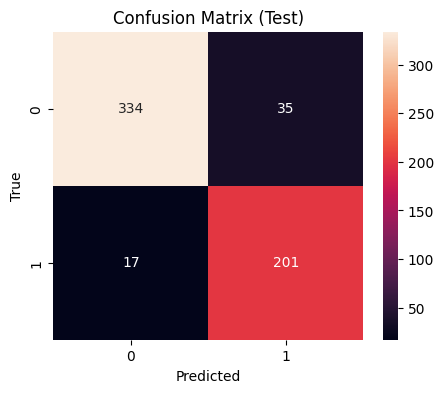

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []
for batch in test_loader:
    batch = batch.to(device)
    out = model(batch.x, batch.edge_index)
    logits = out[:batch.batch_size]
    y = batch.y[:batch.batch_size]
    mask = (y != -1)

    all_preds.append(logits.argmax(dim=1)[mask].cpu())
    all_labels.append(y[mask].cpu())

y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()
print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 🕵️‍♂️ Интерпретация предсказаний с **GNNExplainer**
Выберем произвольный корректно классифицированный узел из тестовой выборки и посмотрим, какие рёбра и признаки были наиболее важны для модели.

## 💾 Сохранение обученной модели

In [64]:
MODEL_PATH = Path('./checkpoints/gcn_model.pt')
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), MODEL_PATH)
print(f'Модель сохранена в {MODEL_PATH.resolve()}')

Модель сохранена в /Users/a1234/Fraud/gnn/checkpoints/gcn_model.pt
